# Compartment Volume Comparison
Comparing the volumes of mitochondria within each labeled neuronal compartment

In [1]:
# just getting past the weird Static TLS thing...
from meshparty import trimesh_io

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

from lib import compartment, plot, u
from importlib import reload

In [2]:
MITODF_FILENAME = "data/pni_mito_cellswskel_v185.csv"
DISTDF_FILENAME = "data/mito_to_skel_v185.h5"
CLEANIDS_FILENAME = "data/clean_compartment_ids_v185.csv"

### Reading data

In [3]:
mitodf = pd.read_csv(MITODF_FILENAME, index_col=0)
distdf = compartment.read_dist_df(DISTDF_FILENAME)
cleanids = u.read_ids(CLEANIDS_FILENAME)

In [4]:
mitodf.head()

,mito_vx,ctr_pos_x_vx,ctr_pos_y_vx,ctr_pos_z_vx,bbox_beg_x_vx,bbox_beg_y_vx,bbox_beg_z_vx,bbox_end_x_vx,bbox_end_y_vx,bbox_end_z_vx,cellid,ctr_pos_x_nm,ctr_pos_y_nm,ctr_pos_z_nm
mito_id,,,,,,,,,,,,,,
1783325,527936,75186,43844,1430,74824,43668,1323,75472,44120,1561,648518346349523993,300744,175376,57200
3272360,354680,101562,47000,241,101260,46750,191,101750,47228,303,648518346349538711,406248,188000,9640
1776789,523452,74500,43210,1457,73444,42632,1401,75636,43732,1564,648518346349538102,298000,172840,58280
2158922,4428,81214,54992,1230,81172,54962,1228,81254,55018,1235,648518346349538730,324856,219968,49200
2158896,11196,81194,53124,2007,81142,53096,2004,81250,53168,2014,648518346349532295,324776,212496,80280


### Restricting analysis to PyCs with QC'd compartment labels

In [5]:
mitodf = mitodf[mitodf.cellid.isin(cleanids)]

### Assigning compartment labels to mitochondria

In [6]:
ids, lbls = compartment.majority_vote_label(distdf)
lbl_lookup = dict(zip(ids, lbls))
mitodf.loc[:, "nodelbl"] = np.array([lbl_lookup[i] for i in mitodf.index])

# Plots

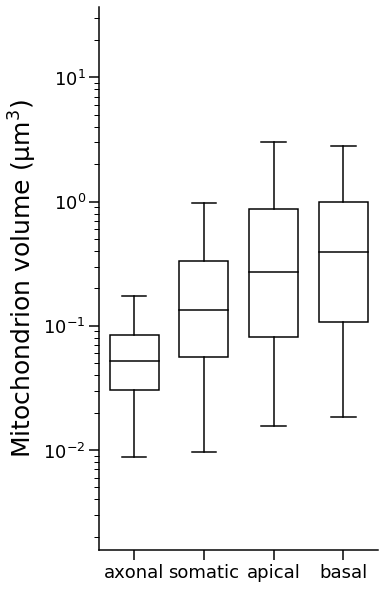

In [7]:
plt.figure(figsize=(5, 10))
plotdf = plot.panelD(mitodf)

plot.plt.show()

### Removing mitochondria with zero minimum distance to a soma node

In [8]:
# Need to do this to preserve the cellid datatype (pandas likes to make things into floats)
mitoids = compartment.read_dist_data("mitoids", filename=DISTDF_FILENAME)
cellids = compartment.read_dist_data("cellid", filename=DISTDF_FILENAME)
cellid_lookup = {m: c for (m, c) in zip(mitoids, cellids)}

In [9]:
distdf_mean = distdf.groupby("mitoids").mean().drop(["nodeids", "nodelbls", "cellid"], axis=1)
distdf_mean["nodelbl"] = np.array([lbl_lookup[i] for i in distdf_mean.index])
distdf_mean["cellid"] = np.array([cellid_lookup[i] for i in distdf_mean.index])

In [10]:
distdf_min = distdf.groupby("mitoids").min().drop(["nodeids", "nodelbls", "cellid"], axis=1)
distdf_min["nodelbl"] = np.array([lbl_lookup[i] for i in distdf_min.index])
distdf_min["cellid"] = np.array([cellid_lookup[i] for i in distdf_min.index])

In [11]:
distdf_mean.shape, distdf_min.shape

((210975, 4), (210975, 4))

In [12]:
idsnearsoma = distdf_min.index[(distdf_min.nodedists == 0) &
                               (distdf_min.nodelbl != 0)].tolist()

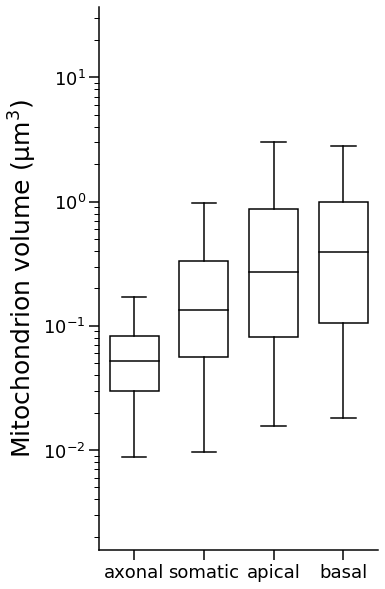

In [13]:
plt.figure(figsize=(5, 10))
plot.panelD(mitodf, idsnearsoma=idsnearsoma)

plot.plt.show()

### Statistics

In [14]:
axon_to_soma = stats.mannwhitneyu(
    plotdf.vol[plotdf.compartment == "axonal"],
    plotdf.vol[plotdf.compartment == "somatic"],
    alternative="less")

soma_to_apical = stats.mannwhitneyu(
    plotdf.vol[plotdf.compartment == "somatic"],
    plotdf.vol[plotdf.compartment == "apical"],
    alternative="less")

apical_to_basal = stats.mannwhitneyu(
    plotdf.vol[plotdf.compartment == "apical"],
    plotdf.vol[plotdf.compartment == "basal"],
    alternative="less")

In [15]:
plotdf.groupby("compartment")["vol"].count()

compartment
apical      7917
axonal      3754
basal      20033
somatic    29678
Name: vol, dtype: int64

In [16]:
axon_to_soma

MannwhitneyuResult(statistic=29401046.5, pvalue=0.0)

In [17]:
soma_to_apical

MannwhitneyuResult(statistic=86985950.0, pvalue=5.512816571268197e-277)

In [18]:
apical_to_basal

MannwhitneyuResult(statistic=72893896.0, pvalue=2.799750439677269e-26)

### Re-plotting with significance annotations

In [19]:
p95s = list()
for comp in ['axonal', 'somatic', 'apical', 'basal']:
    subdf = plotdf[plotdf.compartment == comp]
    p95s.append(np.percentile(subdf.vol, 95))
    

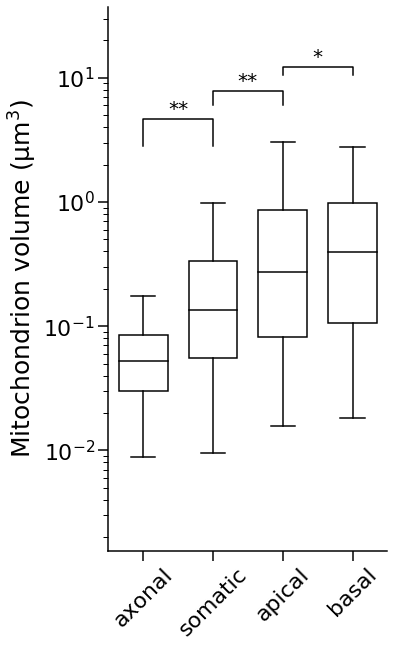

In [20]:
plt.figure(figsize=(5, 10))
plot.panelD(mitodf)

plot.barplot_annotate_brackets(0, 1, '**', np.arange(4), p95s)
plot.barplot_annotate_brackets(1, 2, '**', np.arange(4), p95s, dh=0.08)
plot.barplot_annotate_brackets(2, 3, '*', np.arange(4), p95s, dh=.2)

plt.xticks(rotation=45, fontsize=22)
plt.yticks(fontsize=22)

plot.plt.show()